# Importando as bibliotecas:

In [ ]:
# Importando as libs do pytorch:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models

# Utilitários:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split

# Configurando o uso de gpu: (se disponível)

Antes vá em: (Editar -> Configurações de notebook) e escolha uma opção diferente de cpu

In [ ]:
# Confirmando que estamos utilizando GPU:
!nvidia-smi

Sun Apr 21 23:15:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Definindo o dispositivo:
if torch.cuda.is_available():
    print("GPU disponível. Usando GPU.")
    device = torch.device('cuda')
else:
    print("GPU não disponível. Usando CPU.")
    device = torch.device('cpu')

GPU disponível. Usando GPU.


# Baixando e preparando nosso dataset:

In [ ]:
# Transformações para pré-processamento das imagens
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte as imagens para tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza as imagens
])

# Carrega o conjunto de dados CIFAR-10 de treinamento e teste
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(len(train_dataset))
print(len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [ ]:
# Dividindo os dados em conjuntos de treinamento e validação usando train_test_split do sklearn
train_data, val_data = train_test_split(train_dataset, test_size=0.1, random_state=42)

In [ ]:
# Criando os DataLoaders para treinamento, validação e teste
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Tamanho do conjunto de dados de treinamento:", len(train_data))
print("Tamanho do conjunto de dados de validação:", len(val_data))
print("Tamanho do conjunto de dados de teste:", len(test_dataset))

Tamanho do conjunto de dados de treinamento: 45000
Tamanho do conjunto de dados de validação: 5000
Tamanho do conjunto de dados de teste: 10000


# Visualizando nossos dados:

In [ ]:
classes = {
    0: 'Avião',
    1: 'Carro',
    2: 'Pássaro',
    3: 'Gato',
    4: 'Cervo',
    5: 'Cachorro',
    6: 'Sapo',
    7: 'Cavalo',
    8: 'Navio',
    9: 'Caminhão'
}

In [ ]:
# Função para converter de tensor para imagem:
def converter_imagem(tensor):
  imagem = tensor.clone().detach().numpy()
  imagem = imagem.transpose(1,2,0)
  imagem = (imagem - imagem.min()) / (imagem.max() - imagem.min())
  imagem = imagem.clip(0,1)
  return imagem

# Função para exibir várias imagens
def grade_imagens(train_loader, classes):
    fig = plt.figure(figsize=(6,4))
    fig.subplots_adjust(hspace=1)

    # Acessando o primeiro batch diretamente
    batch = next(iter(train_loader))
    imagens, rotulos = batch

    for idx in np.arange(4):
        ax = fig.add_subplot(2,2,idx+1)
        plt.imshow(converter_imagem(imagens[idx]))
        ax.set_title(f"Label: {classes[rotulos[idx].item()]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

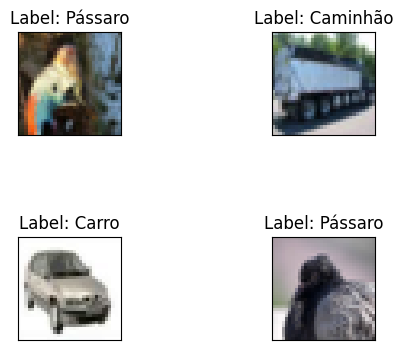

In [ ]:
# Visualizando algumas imagens do nosso dataset:
grade_imagens(train_loader, classes)

# Definindo o nossos modelos:

In [ ]:
class Modelo_MLP(nn.Module):
    def __init__(self):
        super(Modelo_MLP, self).__init__()

        # Camadas da rede neural
        self.flatten = nn.Flatten()               # Camada que converte a entrada para um vetor
        self.fc1 = nn.Linear(32 * 32 * 3, 256)    # Camada de entrada -> intermediária
        self.relu = nn.ReLU()                     # Função de ativação
        self.dropout = nn.Dropout(p=0.5)          # Camada de dropout com probabilidade de 0.5
        self.fc2 = nn.Linear(256, 10)             # Camada intermediária -> saída

    # Definindo a passagem dos dados
    def forward(self, x):
        # Passagem dos dados através das camadas
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class Modelo_CNN(nn.Module):
    def __init__(self):
        super(Modelo_CNN, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Camadas da convolução, pooling e padding
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Camadas da rede neural
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    # Definindo a passagem dos dados
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Definindo hiperparâmetros, otimizadores, critério e instânciando o modelo:

In [ ]:
criterio = nn.CrossEntropyLoss()                                      # Definindo o critério para o cálculo da perca
taxa_de_aprendizado = 0.001                                           # Definindo o valor da nossa taxa de aprendizado

modelo_mlp = Modelo_MLP()
otimizador_mlp = optim.Adam(modelo_mlp.parameters(), lr=taxa_de_aprendizado)

# Intânciando nossos modelos e qual otimizador utilizaremos para atualizar os pesos
modelo_cnn = Modelo_CNN()
otimizador_cnn = optim.Adam(modelo_cnn.parameters(), lr=taxa_de_aprendizado)

In [ ]:
# Move os modelos para a GPU, se disponível
modelo_mlp = modelo_mlp.to(device)
modelo_cnn = modelo_cnn.to(device)

# Visualizando as estruturas dos modelos
print(modelo_mlp)
print()
print(modelo_cnn)

Modelo_MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Modelo_CNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


# Definindo nossas funções de treino, validação e teste:

In [ ]:
def Validacao(modelo, val_loader, criterio, device):
    modelo.eval()                                   # Define o modelo no modo de avaliação
    total_acertos = 0
    total_exemplos = 0
    epoch_loss = 0.0

    with torch.no_grad():                           # Desativa o cálculo de gradientes durante a validação
        for batch in val_loader:
            imagens, rotulos = batch
            imagens, rotulos = imagens.to(device), rotulos.to(device)
            saidas = modelo(imagens)
            loss = criterio(saidas, rotulos)
            epoch_loss += loss.item()

            _, previsoes = torch.max(saidas, 1)    # Obtém as previsões do modelo
            total_acertos += (previsoes == rotulos).sum().item()
            total_exemplos += rotulos.size(0)

    # Calcula a acurácia e a loss média para a época de validação
    avg_epoch_loss = epoch_loss / len(val_loader)
    accuracy = total_acertos / total_exemplos

    print(f'Loss de validação média: {avg_epoch_loss:.3f}, Acurácia de validação: {accuracy:.3f}\n')
    modelo.train()  # Retorna o modelo ao modo de treinamento
    return avg_epoch_loss, accuracy

In [ ]:
def Treinamento(epocas, modelo, train_loader, val_loader, criterio, otimizador, device):
  train_losses = []
  train_accuracies = []
  valid_losses = []
  valid_accuracies = []
  inicio = time.time()
  for epoca in range(epocas):
      epoch_loss = 0.0
      correct_predictions = 0
      total_predictions = 0                                         # Inicializa/zera a loss para a época
      for batch in train_loader:                                      # Iterando sobre cada conjunto de dados no loader
          imagens, rotulos = batch
          imagens, rotulos = imagens.to(device), rotulos.to(device)   # Move os dados para a GPU, se disponível
          otimizador.zero_grad()                                      # Zerando o valor dos gradientes para não acumular
          saidas = modelo(imagens)                                    # Realizando as predições com o modelo
          loss = criterio(saidas, rotulos)                            # Calculando o erro na predição com o nosso critério
          loss.backward()                                             # Propagando o erro pela rede
          otimizador.step()                                           # Atualizando os pesos com o nosso otimizador
          epoch_loss += loss.item()                                   # Acumula a loss para a época

          _, previsoes = torch.max(saidas, 1)  # Obtém as previsões do modelo
          correct_predictions += (previsoes == rotulos).sum().item()
          total_predictions += rotulos.size(0)

      # Calculando a média da loss para a época
      avg_train_loss = epoch_loss / len(train_loader)
      train_accuracy = correct_predictions / total_predictions

      # Exibindo a loss média para a época
      print(f'Época {epoca + 1}/{epocas}:\nLoss de treinamento média: {avg_train_loss:.3f}, Acurácia de treinamento: {train_accuracy:.3f}')

      # Realiza a validação após cada época de treinamento
      avg_valid_loss, val_accuracy = Validacao(modelo, val_loader, criterio, device)

      train_losses.append(avg_train_loss)
      valid_losses.append(avg_valid_loss)
      train_accuracies.append(train_accuracy)
      valid_accuracies.append(val_accuracy)

  fim = time.time()
  print(f"Treinamento concluído em {fim-inicio:.2f} segundos")
  return modelo, train_losses, valid_losses, train_accuracies, valid_accuracies

In [ ]:
# Teste o modelo no conjunto de teste
def Teste_modelo(modelo, test_loader):
  modelo.eval()                                                     # Configurando o modelo para modo de avaliação (não alterar nenhuma parâmetro)
  corretos = 0
  total = 0
  with torch.no_grad():                                             # Congela a atualização dos gradientes (não mexer nos valores dos gradientes)
      for batch in test_loader:
          imagens, rotulos = batch
          imagens, rotulos = imagens.to(device), rotulos.to(device) # Move os dados para a GPU, se disponível
          saidas = modelo(imagens)
          _, previsao = torch.max(saidas.data, 1)
          total += rotulos.size(0)
          corretos += (previsao == rotulos).sum().item()

  acuracia = corretos / total
  print(f'Acurácia no teste: {acuracia * 100:.2f}%')

# Realizando treinamento e teste com o nosso modelo:

In [ ]:
# Definindo o número de épocas
epocas = 5

# Treinamento do modelo
modelo_mlp, train_losses, valid_losses, train_accuracies, valid_accuracies = Treinamento(epocas, modelo_mlp, train_loader, val_loader, criterio, otimizador_mlp, device)

Época 1/5:
Loss de treinamento média: 1.817, Acurácia de treinamento: 0.366
Loss de validação média: 1.593, Acurácia de validação: 0.434

Época 2/5:
Loss de treinamento média: 1.676, Acurácia de treinamento: 0.411
Loss de validação média: 1.572, Acurácia de validação: 0.441

Época 3/5:
Loss de treinamento média: 1.641, Acurácia de treinamento: 0.427
Loss de validação média: 1.549, Acurácia de validação: 0.457

Época 4/5:
Loss de treinamento média: 1.605, Acurácia de treinamento: 0.439
Loss de validação média: 1.543, Acurácia de validação: 0.459

Época 5/5:
Loss de treinamento média: 1.584, Acurácia de treinamento: 0.448
Loss de validação média: 1.488, Acurácia de validação: 0.474

Treinamento concluído em 8.59 segundos


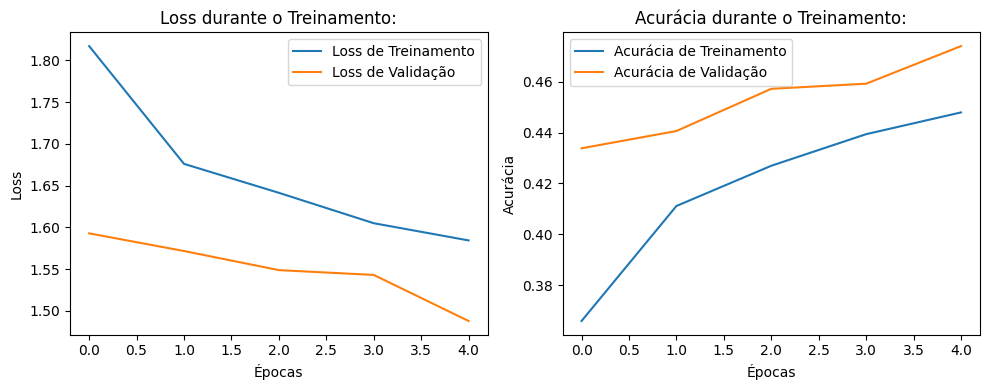

In [ ]:
# Definindo o tamanho da figura
plt.figure(figsize=(10, 4))

# Plotando as losses
plt.subplot(1, 2, 1)  # subplot com 1 linha, 2 colunas, este é o primeiro subplot
plt.plot(train_losses, label='Loss de Treinamento')
plt.plot(valid_losses, label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss durante o Treinamento:')
plt.legend()

# Plotando as acurácias
plt.subplot(1, 2, 2)  # subplot com 1 linha, 2 colunas, este é o segundo subplot
plt.plot(train_accuracies, label='Acurácia de Treinamento')
plt.plot(valid_accuracies, label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia durante o Treinamento:')
plt.legend()

# Mostrando os subplots
plt.tight_layout()
plt.show()

In [ ]:
# Definindo o número de épocas
epocas = 5

# Treinamento do modelo
modelo_cnn, train_losses, valid_losses, train_accuracies, valid_accuracies = Treinamento(epocas, modelo_cnn, train_loader, val_loader, criterio, otimizador_cnn, device)

Época 1/5:
Loss de treinamento média: 1.502, Acurácia de treinamento: 0.459
Loss de validação média: 1.187, Acurácia de validação: 0.581

Época 2/5:
Loss de treinamento média: 1.160, Acurácia de treinamento: 0.586
Loss de validação média: 1.005, Acurácia de validação: 0.642

Época 3/5:
Loss de treinamento média: 1.013, Acurácia de treinamento: 0.641
Loss de validação média: 0.903, Acurácia de validação: 0.674

Época 4/5:
Loss de treinamento média: 0.910, Acurácia de treinamento: 0.678
Loss de validação média: 0.867, Acurácia de validação: 0.692

Época 5/5:
Loss de treinamento média: 0.843, Acurácia de treinamento: 0.705
Loss de validação média: 0.854, Acurácia de validação: 0.699

Treinamento concluído em 13.35 segundos


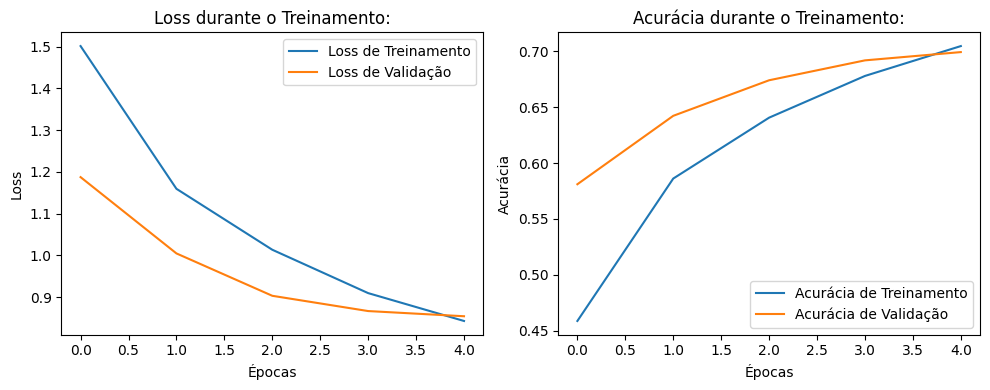

In [ ]:
# Definindo o tamanho da figura
plt.figure(figsize=(10, 4))

# Plotando as losses
plt.subplot(1, 2, 1)  # subplot com 1 linha, 2 colunas, este é o primeiro subplot
plt.plot(train_losses, label='Loss de Treinamento')
plt.plot(valid_losses, label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss durante o Treinamento:')
plt.legend()

# Plotando as acurácias
plt.subplot(1, 2, 2)  # subplot com 1 linha, 2 colunas, este é o segundo subplot
plt.plot(train_accuracies, label='Acurácia de Treinamento')
plt.plot(valid_accuracies, label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia durante o Treinamento:')
plt.legend()

# Mostrando os subplots
plt.tight_layout()
plt.show()

In [ ]:
# Avaliação do modelo criado
Teste_modelo(modelo_mlp, test_loader)
print()
Teste_modelo(modelo_cnn, test_loader)

Acurácia no teste: 49.33%

Acurácia no teste: 70.57%


# Visualizando uma predição em um dado separado:

In [ ]:
def exibir_predicao(modelo_escolhido, dataset, classes):
    # Escolhendo uma imagem aleatória do conjunto de teste
    rand_idx = np.random.randint(len(dataset))
    image, label = dataset[rand_idx]

    # Adicionando uma dimensão para o lote
    image = image.unsqueeze(0)

    # Move a imagem para o dispositivo (GPU ou CPU)
    image = image.to(device)

    # Fazendo uma predição com o modelo_escolhido treinado
    modelo_escolhido.eval()
    with torch.no_grad():
        output = modelo_escolhido(image)  # Adiciona uma dimensão para o lote

    # Obtendo a classe prevista e a probabilidade associada
    predicted_probs = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(output, 1)

    # Convertendo a imagem de tensor PyTorch para numpy array e reajustando as dimensões
    image = image.cpu().squeeze().numpy().transpose((1, 2, 0))

    # Normalizando a imagem
    image = (image - image.min()) / (image.max() - image.min())

    # Exibindo a imagem e informações sobre a predição
    plt.imshow(image)
    plt.title(f'Real: {classes[label]}, Predição: {classes[predicted_class.item()]}')
    plt.show()
    print(f"Probabilidade: {(predicted_probs.squeeze()[predicted_class.item()].item())*100:.2f}%")


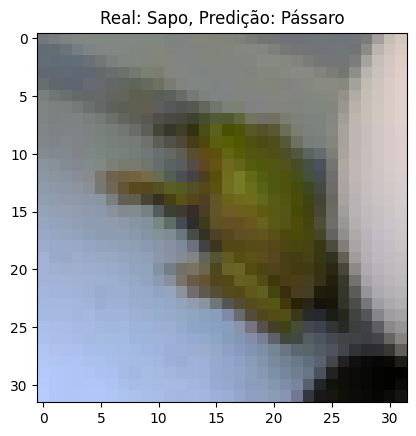

Probabilidade: 69.28%


In [ ]:
# Realiza predição e exibe
exibir_predicao(modelo_cnn, test_dataset, classes)

# Salvando o nosso modelo treinado:

In [ ]:
def salvar_modelo(modelo, nome_modelo):
    caminho_diretorio = './modelos'

    if not os.path.exists(caminho_diretorio):
        os.makedirs(caminho_diretorio)
        print(f'Diretório {caminho_diretorio} criado com sucesso!')
    else:
        print(f'O diretório {caminho_diretorio} já existe.')

    caminho_arquivo = f'./modelos/{nome_modelo}.pth'
    torch.save(modelo.state_dict(), caminho_arquivo)

In [ ]:
# Salvando o modelo treinado
nome_modelo = 'modelo_cnn'
salvar_modelo(modelo_cnn, nome_modelo)

O diretório ./modelos já existe.


In [ ]:
#Baixando o arquivo .pth para a máquina local
from google.colab import files
files.download('./modelos/modelo_cnn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>